# Ejercicio: índice de marginación

Buscaremos representaciones de dimensión uno para los datos de marginación (2010) a nivel municipio de CONAPO.

In [1]:
%autosave 0
import pandas as pd
import numpy as np
from plotnine import *

Autosave disabled


## 1. Descripción de datos

Leemos los datos y vemos una descripción

In [2]:
marginacion = pd.read_csv("../datos/imm-2010.csv")
descrip = pd.read_csv("../datos/imm-2010-descrip.csv", skiprows=2)
pd.set_option('max_colwidth', 200)
descrip

,Variable,Descripción
0,CVE_ENT,Clave de la entidad federativa
1,NOM_ENT,Nombre de la entidad federativa
2,CVE_MUN,Clave del municipio
3,NOM_MUN,Nombre del municipio
4,POB_TOT,Población total
5,ANALF,Porcentaje de población de 15 años o más analfabeta
6,SPRIM,Porcentaje de población de 15 años o más sin primaria completa
7,OVSDE,Porcentaje de ocupantes en viviendas sin drenaje ni excusado
8,OVSEE,Porcentaje de ocupantes en viviendas sin energía eléctrica
9,OVSAE,Porcentaje de ocupantes en viviendas sin agua entubada


In [3]:
marginacion

,CVE_MUN,CVE_ENT,NOM_ENT,NOM_MUN,POB_TOT,ANALF,SPRIM,OVSDE,OVSEE,OVSAE,VHAC,OVPT,PL_5000,PO2SM,IM,GM
0,9012,9,Distrito Federal,Tlalpan,650567,2.25,9.46,0.13,0.23,11.37,26.07,1.46,1.78,25.60,-1.79,Muy bajo
1,9013,9,Distrito Federal,Xochimilco,415007,2.73,9.92,0.19,0.31,6.69,32.80,2.38,1.72,32.72,-1.64,Muy bajo
2,9008,9,Distrito Federal,La Magdalena Contreras,239086,2.65,11.13,0.10,0.09,3.57,30.83,1.36,0.27,26.99,-1.75,Muy bajo
3,9002,9,Distrito Federal,Azcapotzalco,414711,1.63,7.19,0.03,0.01,0.17,23.39,0.60,0.00,24.34,-1.99,Muy bajo
4,9014,9,Distrito Federal,Benito Juarez,385439,0.56,3.06,0.02,0.01,0.04,8.19,0.26,0.00,17.07,-2.34,Muy bajo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,29045,29,Tlaxcala,Benito Juarez,5687,7.50,19.00,0.25,0.46,0.00,50.19,2.01,0.23,48.43,-1.09,Bajo
2452,4011,4,Campeche,Candelaria,41194,15.78,36.60,13.15,13.93,15.06,54.42,16.10,76.18,75.37,0.66,Alto
2453,4010,4,Campeche,Calakmul,26882,17.87,36.56,7.98,6.44,31.40,64.49,13.48,100.00,79.66,0.84,Alto
2454,23008,23,Quintana Roo,Solidaridad,159310,2.81,11.60,0.24,0.70,1.09,43.78,1.72,2.14,23.52,-1.60,Muy bajo


Calculamos algunos resúmenes de las variables numéricas (excluyendo el índice de marginación oficial)

In [4]:
marg_tabla = marginacion.loc[:,'ANALF':'PO2SM']
marg_tabla
# Cuantiles 0.1, 0.5 (mediana) y 0.9 , 0.99
marg_tabla.quantile([0, .10, 0.5, 0.9, 0.99, 1]).stack().unstack(0).round(1)

,0.00,0.10,0.50,0.90,0.99,1.00
ANALF,0.6,3.8,11.9,27.9,42.5,66.7
SPRIM,3.1,16.0,34.5,50.9,64.9,81.3
OVSDE,0.0,0.6,3.5,17.9,47.7,89.8
OVSEE,0.0,0.5,2.2,8.8,31.8,69.4
OVSAE,0.0,0.7,7.0,40.8,76.4,99.7
VHAC,8.2,29.1,43.7,61.8,74.6,83.2
OVPT,0.0,1.9,8.7,29.4,51.3,79.7
PL_5000,0.0,14.8,100.0,100.0,100.0,100.0
PO2SM,6.4,33.6,63.4,86.2,94.8,98.9


Todas las variables son porcentajes, y sus escalas no son tan distintas (argumenta).

## 2. Aproximación de rango 1

Nos interesa ahora construir una aproximación de rango 1 a esta tabla de datos de municipios. La idea principal
es que si construimos una aproximación $X\approx uv^t$, el vector $u$, cuya longitud es el número de municipios,
nos de una **medición general de marginación**. Tendremos que checar que esta interpretación es la correcta.

En primer lugar, no daremos tratamiento a los indicadores. Usamos la función svd para extraer la primera componente (ver notas)

In [5]:
from numpy.linalg import svd
u, s, v_t = svd(marg_tabla.values)
signo = -1
u = signo * u[:, 0].reshape(-1, 1)
v = signo * v_t[0, :].reshape(-1, 1)
s = s[0]

Examina los pesos en el vector $v$ que corresponde a las variables:

In [6]:
pesos_variables = pd.DataFrame(v, index = marg_tabla.columns).rename(columns={0:'v'})
pesos_variables.sort_values(by='v')

,v
OVSEE,0.038806
OVSDE,0.062933
OVPT,0.117710
ANALF,0.130349
OVSAE,0.136773
SPRIM,0.299345
VHAC,0.373282
PO2SM,0.535470
PL_5000,0.655214


**Pregunta**: ¿cómo interpretas estos números en término de la tabla de datos?

## 3. Calidad de la aproximación

Calcula la aproximación de rango 1 y compara contra los observados en la tabla

In [7]:
X_1 = s * np.matmul(u, v.transpose())

In [8]:
X_1.shape

(2456, 9)

In [9]:
# Calcula residuales
R = X_1 - marg_tabla.values
R.shape

(2456, 9)

In [10]:
# Calcula porcentaje de tamaño de residuales vs tamaño de la tabla
error_relativo = np.sum(R**2) / np.sum(marg_tabla.values**2)
error_relativo.round(2)

0.07

## 4. Examinar scores de municipios

Haz un histograma o gráfica de cuantiles de los scores de los municipios

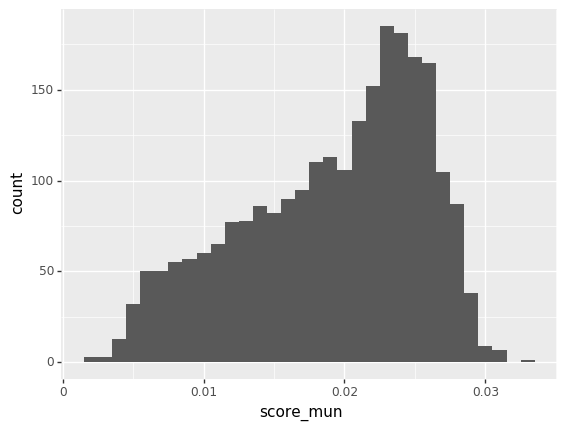

<ggplot: (8737115121861)>

In [11]:
# Agrega a la tabla los scores
marginacion['score_mun'] = u
# Grafica
ggplot(marginacion, aes('score_mun')) + geom_histogram(binwidth = 0.001)

**Pregunta**: considerando el vector $v$ de pesos que vimos arriba y estos scores, ¿cómo interpretas el score de 
    municipios que acabamos de calcular?

## 5. Municipios de score bajos y altos

Encuentra el 1% municipios con score más bajo y el 1% con score más alto

In [12]:
marginacion['rank_score'] = marginacion['score_mun'].rank(method = 'first') / len(marginacion)
marginacion.loc[ marginacion['rank_score'] <= 0.01 ]

,CVE_MUN,CVE_ENT,NOM_ENT,NOM_MUN,POB_TOT,ANALF,SPRIM,OVSDE,OVSEE,OVSAE,VHAC,OVPT,PL_5000,PO2SM,IM,GM,score_mun,rank_score
3,9002,9,Distrito Federal,Azcapotzalco,414711,1.63,7.19,0.03,0.01,0.17,23.39,0.60,0.00,24.34,-1.99,Muy bajo,0.004095,0.005293
4,9014,9,Distrito Federal,Benito Juarez,385439,0.56,3.06,0.02,0.01,0.04,8.19,0.26,0.00,17.07,-2.34,Muy bajo,0.002235,0.000814
5,9015,9,Distrito Federal,Cuauhtemoc,531831,1.44,6.45,0.05,0.05,0.08,19.42,0.33,0.00,26.07,-2.04,Muy bajo,0.003952,0.003664
6,9010,9,Distrito Federal,alvaro Obregon,727034,2.19,9.43,0.04,0.04,0.76,26.94,1.18,0.05,23.64,-1.90,Muy bajo,0.004412,0.006922
9,9016,9,Distrito Federal,Miguel Hidalgo,372889,1.21,6.02,0.02,0.02,0.03,17.06,0.52,0.00,20.63,-2.13,Muy bajo,0.003286,0.001629
10,9006,9,Distrito Federal,Iztacalco,384326,1.79,8.19,0.03,0.02,0.04,25.31,0.75,0.00,26.09,-1.93,Muy bajo,0.004428,0.007329
11,9003,9,Distrito Federal,Coyoacan,620416,1.55,6.48,0.09,0.02,0.06,18.00,0.85,0.00,20.23,-2.11,Muy bajo,0.003348,0.002443
100,15121,15,Mexico,Cuautitlan Izcalli,511675,1.61,7.00,0.12,0.47,1.88,20.91,1.53,1.90,28.73,-1.94,Muy bajo,0.004598,0.008958
161,15054,15,Mexico,Metepec,214162,1.85,7.16,0.42,0.27,1.68,21.80,2.36,7.45,21.14,-1.96,Muy bajo,0.004609,0.009772
193,15020,15,Mexico,Coacalco de Berriozabal,278064,0.97,4.94,0.06,0.04,0.24,18.37,1.57,0.04,28.15,-2.05,Muy bajo,0.004020,0.004072


In [13]:
marginacion.loc[ marginacion['rank_score'] >= 0.99 ]

,CVE_MUN,CVE_ENT,NOM_ENT,NOM_MUN,POB_TOT,ANALF,SPRIM,OVSDE,OVSEE,OVSAE,VHAC,OVPT,PL_5000,PO2SM,IM,GM,score_mun,rank_score
58,12069,12,Guerrero,Xalpatlahuac,12240,42.57,59.68,44.45,4.64,83.15,66.37,15.72,100.0,84.42,2.50,Muy alto,0.029599,0.993485
63,12062,12,Guerrero,Tlacoachistlahuaca,21306,49.11,66.95,57.40,14.37,8.06,72.67,30.88,100.0,83.38,2.81,Muy alto,0.029181,0.991450
65,12004,12,Guerrero,Alcozauca de Guerrero,18971,50.06,67.27,52.85,5.00,60.52,66.01,20.98,100.0,82.38,2.75,Muy alto,0.029614,0.993893
66,12043,12,Guerrero,Metlatonoc,18976,52.50,68.55,58.31,11.12,18.97,72.09,39.67,100.0,93.08,3.12,Muy alto,0.030594,0.998779
686,8008,8,Chihuahua,Batopilas,14362,38.07,62.22,56.69,66.42,86.25,62.72,25.52,100.0,84.81,3.95,Muy alto,0.030235,0.995114
811,7022,7,Chiapas,Chalchihuitan,14027,33.82,49.40,12.66,18.45,69.04,76.75,55.80,100.0,93.41,2.74,Muy alto,0.030578,0.998371
821,7007,7,Chiapas,Amatenango del Valle,8728,32.97,60.57,20.11,5.27,31.83,65.78,37.10,100.0,93.27,2.06,Muy alto,0.029180,0.990635
846,7082,7,Chiapas,Sitala,12269,46.49,68.79,55.40,19.36,39.37,77.59,25.80,100.0,87.45,3.12,Muy alto,0.030530,0.997557
950,20048,20,Oaxaca,Magdalena Mixtepec,1304,25.68,49.42,0.94,2.02,53.78,76.96,33.05,100.0,92.84,1.71,Muy alto,0.029324,0.991857
955,20051,20,Oaxaca,Magdalena Teitipac,4368,35.87,71.45,2.57,2.37,57.59,65.77,22.50,100.0,84.84,1.95,Muy alto,0.029130,0.990228


**Pregunta**: ¿donde están ubicados los diez menos marginados y los diez más marginados? ¿Cómo se ven sus variables indicadoras en cada caso?

## 6. Normalización de variables

Como vimos antes, las variables que usamos tienen distintos niveles y dispersión. Esto produce que pesen más en el ajuste variables que tienen valores altos (pues influyen más en el error de aproximación). Podemos fijar la escala de las variables de entrada para evitar este efecto.

Hay varias maneras de hacer esto (por ejemplo, restando media y dividiendo por desviación estándar, que veremos más adelante). Una manera es normalizando para el rango de las variables esté entre 0 y 1, excluyendo valores atípicos

In [14]:
#normaliza tabla para que esté aproximadamente entre 0 y 1
#usamos un cuantil en lugar del máximo para no aplastar tanto 
#debido a atípicos superiores
max_c = marg_tabla.quantile(0.95)
max_c

ANALF       33.5400
SPRIM       54.9925
OVSDE       25.7400
OVSEE       13.5200
OVSAE       52.4975
VHAC        66.7600
OVPT        37.6625
PL_5000    100.0000
PO2SM       90.1725
Name: 0.95, dtype: float64

In [15]:
marg_tabla_norm = marg_tabla / max_c
marg_tabla_norm

,ANALF,SPRIM,OVSDE,OVSEE,OVSAE,VHAC,OVPT,PL_5000,PO2SM
0,0.067084,0.172023,0.005051,0.017012,0.216582,0.390503,0.038765,0.0178,0.283900
1,0.081395,0.180388,0.007382,0.022929,0.127435,0.491312,0.063193,0.0172,0.362860
2,0.079010,0.202391,0.003885,0.006657,0.068003,0.461803,0.036110,0.0027,0.299315
3,0.048599,0.130745,0.001166,0.000740,0.003238,0.350359,0.015931,0.0000,0.269927
4,0.016696,0.055644,0.000777,0.000740,0.000762,0.122678,0.006903,0.0000,0.189304
...,...,...,...,...,...,...,...,...,...
2451,0.223614,0.345502,0.009713,0.034024,0.000000,0.751797,0.053369,0.0023,0.537082
2452,0.470483,0.665545,0.510878,1.030325,0.286871,0.815159,0.427481,0.7618,0.835842
2453,0.532797,0.664818,0.310023,0.476331,0.598124,0.965998,0.357916,1.0000,0.883418
2454,0.083781,0.210938,0.009324,0.051775,0.020763,0.655782,0.045669,0.0214,0.260833


Ahora recalcula la aproximación de rango 1 y compara el índice que encontraste con el IMC reportado en la tabla (el valor oficial)

In [16]:
u, s, v_t = svd(marg_tabla_norm.values)
signo = -1
u = signo * u[:, 0].reshape(-1, 1)
v = signo * v_t[0, :].reshape(-1, 1)
s = s[0]
u

array([[0.00537531],
       [0.00626394],
       [0.00551302],
       ...,
       [0.02508784],
       [0.0065061 ],
       [0.01313154]])

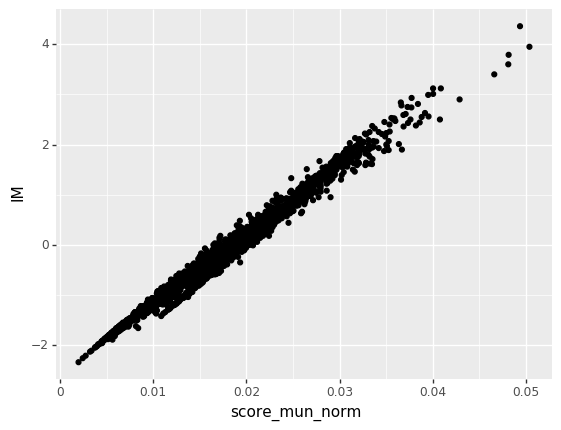

<ggplot: (-9223363299745537648)>

In [17]:
# Agrega a la tabla los scores
marginacion['score_mun_norm'] = u
# Grafica comparando con el 
ggplot(marginacion, aes('score_mun_norm', 'IM')) + geom_point()

Para comparar qué tan similares son las ordenaciones sugeridas por nuestro indice y el oficial, podemo usar la tau de Kendall, que mide que fracción de pares posible están en el mismo orden en los dos índices: 

In [18]:
from scipy.stats import kendalltau
kendalltau(marginacion['score_mun_norm'], marginacion['IM'])

KendalltauResult(correlation=0.924639047954585, pvalue=0.0)

Finalmente, los pesos nuevos son:

In [19]:
pesos_variables = pd.DataFrame(v, index = marg_tabla.columns).rename(columns={0:'v'})
pesos_variables.sort_values(by='v')

,v
OVSDE,0.190187
OVSAE,0.201620
OVSEE,0.232303
OVPT,0.236664
ANALF,0.291656
SPRIM,0.398567
VHAC,0.409435
PO2SM,0.430539
PL_5000,0.465063


## 7. Pesos y scores

Veremos ahora un aspecto importante de los vectores $u$ de scores y $v$ de pesos, y de por qué su nombre.
Empezamos recordando los pesos del vector $v$:

In [20]:
pesos_variables = pd.DataFrame(v, index = marg_tabla.columns).rename(columns={0:'v'})
pesos_variables.sort_values(by='v')

,v
OVSDE,0.190187
OVSAE,0.201620
OVSEE,0.232303
OVPT,0.236664
ANALF,0.291656
SPRIM,0.398567
VHAC,0.409435
PO2SM,0.430539
PL_5000,0.465063


Ahora creamos un índice ponderando las variables originales por estos pesos. Esto se hace multiplicando la tabla original $X$ por los pesos $v$:

In [21]:
X = marg_tabla_norm.values
indice_ponderado = np.matmul(X, v)
indice_ponderado.shape

(2456, 1)

Y ahora comparamos con los scores $v$ que calculamos antes:

In [22]:
comp_df = pd.DataFrame(indice_ponderado, columns = ['indice_pond'])
comp_df['sigma*u'] = s * u
comp_df

,indice_pond,sigma*u
0,0.436276,0.436276
1,0.508400,0.508400
2,0.447453,0.447453
3,0.330765,0.330765
4,0.160886,0.160886
...,...,...
2451,0.765422,0.765422
2452,1.945904,1.945904
2453,2.036206,2.036206
2454,0.528055,0.528055


### Los scores $u$ son las variables originales ponderadas por los pesos $v$ (módulo una constante) 

Discutiremos más adelante por qué es cierta en general esta afirmación que nos permite interpetar de manera simple scores y pesos.

## 8. Análisis estandarizando variables

**Pregunta**: repite ahora estandarizando con media y desviación estándar

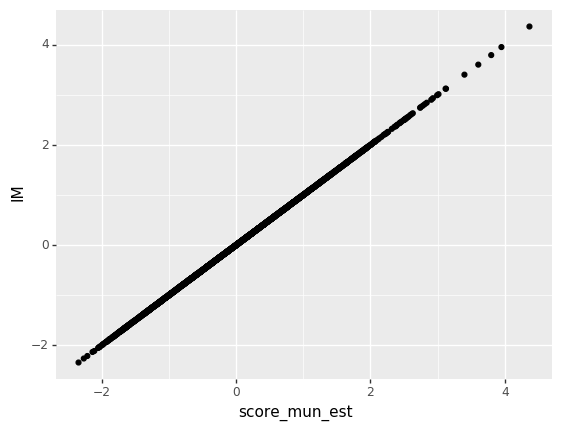

<ggplot: (-9223363299745579937)>

In [23]:
# aquí tu código
marg_tabla_est = (marg_tabla - marg_tabla.mean())/ marg_tabla.std()
# svd
u, s, v_t = svd(marg_tabla_est.values)
signo = 1
u = signo * u[:, 0].reshape(-1, 1)
v = signo * v_t[0, :].reshape(-1, 1)
s = s[0]
#
# Agrega a la tabla los scores, estandarizando u
marginacion['score_mun_est'] = (u - np.mean(u)) / np.std(u)
# Grafica comparando con el 
ggplot(marginacion, aes('score_mun_est', 'IM')) + geom_point()

## 9. Segunda dimensión latente

El índice de marginación nos da la primera aproximación a la tabla de datos de marginación por municipio, y es la mejor
aproximación de rango 1. Buscaremos ahora mejorar nuestra solución agregando otra componente de rango 2

In [24]:
from numpy.linalg import svd
# puedes usar la tabla de standarizados también si la calculaste
# en el ejercicio anterior
U, S, V_t = svd(marg_tabla_norm.values)
signo = -1
u_1 = signo * U[:, 0].reshape(-1, 1)
v_1 = signo * V_t[0, :].reshape(-1, 1)
s_1 = S[0]
v_1

array([[0.29165619],
       [0.39856692],
       [0.19018661],
       [0.23230299],
       [0.20162036],
       [0.40943544],
       [0.23666431],
       [0.46506331],
       [0.43053853]])

La calidad porcentual de aproximación, por lo que acabamos de notar, se calcula como

In [25]:
X_norma = np.sum(marg_tabla_norm.values**2)
X_norma

7976.6106282335695

In [26]:
calidad = s_1**2 / X_norma
calidad

0.8258447280518372

Ahora consideramos la segunda dimensión latente

In [27]:
u_2 = signo * U[:, 1].reshape(-1, 1)
v_2 = signo * V_t[1, :].reshape(-1, 1)
s_2 = S[1]

pesos_variables_2 = pd.DataFrame(v_2, index = marg_tabla_norm.columns).rename(columns={0:'v_2'})
pesos_variables_2.sort_values(by='v_2')

,v_2
PL_5000,-0.245377
PO2SM,-0.204978
VHAC,-0.160712
SPRIM,-0.142030
ANALF,-0.006593
OVPT,0.100887
OVSDE,0.278515
OVSAE,0.288657
OVSEE,0.825020


**Pregunta**: interpeta estos pesos. ¿Cuándo el score de un municipio es alto en esta dimensión? ¿Cuál es el patrón en los datos que está capturando esta segunda dimensión? 

Calcula ahora la calidad de la representación con dos dimensiones latentes

In [28]:
calidad = (s_1**2 + s_2**2) / X_norma
calidad

0.8873949500726797

**Pregunta**. qué tanto aporta esta segunda dimensión en comparación a la primera?

Ahora checa que los dos vectores $u_1$ y $u_2$ son ortogonales (igual para los $v$)

In [29]:
np.matmul(u_1.transpose(), u_2)
np.matmul(v_1.transpose(), v_2)

array([[-6.9388939e-17]])

## 10. Interpretación de segunda dimensión latente

Usa el siguiente código para interpetar la segunda dimensión que encontramos

In [30]:
marginacion = marginacion.drop(['score_mun', 'rank_score', 'score_mun_norm', 'score_mun_est'], axis = 1)

In [31]:
marginacion['score_mun_1'] = u_1
marginacion['score_mun_2'] = u_2
marginacion['rank_score_2'] = marginacion['score_mun_2'].rank(method = 'first') / len(marginacion)
marginacion.loc[ marginacion['rank_score_2'] >= 0.997 ]

,CVE_MUN,CVE_ENT,NOM_ENT,NOM_MUN,POB_TOT,ANALF,SPRIM,OVSDE,OVSEE,OVSAE,VHAC,OVPT,PL_5000,PO2SM,IM,GM,score_mun_1,score_mun_2,rank_score_2
358,18009,18,Nayarit,Del Nayar,34300,33.85,56.12,69.10,61.55,51.54,67.75,29.18,100.00,78.14,3.60,Muy alto,0.048103,0.186277,0.999186
379,14061,14,Jalisco,Mezquitic,18084,27.47,53.47,64.78,50.62,44.83,54.56,37.73,100.00,62.06,2.90,Muy alto,0.042877,0.156883,0.997557
626,10014,10,Durango,Mezquital,33396,28.65,49.46,38.33,65.80,68.05,67.06,45.69,100.00,70.35,3.40,Muy alto,0.046599,0.190745,0.999593
655,8020,8,Chihuahua,Chinipas,8441,13.76,40.36,19.33,60.51,35.04,47.00,19.20,100.00,78.36,1.90,Muy alto,0.036684,0.158054,0.997964
668,8046,8,Chihuahua,Morelos,8343,21.42,47.20,24.61,64.07,62.00,48.66,22.08,100.00,74.81,2.50,Muy alto,0.040765,0.176794,0.998779
686,8008,8,Chihuahua,Batopilas,14362,38.07,62.22,56.69,66.42,86.25,62.72,25.52,100.00,84.81,3.95,Muy alto,0.050372,0.200913,1.000000
697,8027,8,Chihuahua,Guachochi,49689,25.33,48.57,32.13,52.59,58.94,54.64,24.53,70.79,71.46,2.38,Muy alto,0.038186,0.151122,0.997150
1176,20212,20,Oaxaca,San Juan Petlapa,2807,38.54,62.64,0.75,69.45,45.89,68.40,64.65,100.00,94.68,3.79,Muy alto,0.048139,0.174973,0.998371


In [32]:
marginacion.loc[ marginacion['rank_score_2'] <= 0.003]

,CVE_MUN,CVE_ENT,NOM_ENT,NOM_MUN,POB_TOT,ANALF,SPRIM,OVSDE,OVSEE,OVSAE,VHAC,OVPT,PL_5000,PO2SM,IM,GM,score_mun_1,score_mun_2,rank_score_2
974,20267,20,Oaxaca,San Miguel del Rio,294,2.28,33.33,0.34,0.00,0.00,35.71,4.76,100.0,83.02,-0.40,Medio,0.016932,-0.026635,0.002443
1081,20524,20,Oaxaca,Santo Domingo Yodohino,369,21.11,42.75,0.00,0.00,0.00,25.83,17.34,100.0,95.70,0.27,Medio,0.020733,-0.026772,0.002036
1330,20106,20,Oaxaca,San Antonio Acutla,297,22.37,40.91,2.08,0.69,0.00,47.25,5.90,100.0,87.74,0.35,Medio,0.021304,-0.026547,0.002850
1340,20228,20,Oaxaca,San Lorenzo Cuaunecuiltitla,771,30.79,66.11,0.00,1.04,11.02,67.26,11.54,100.0,91.10,1.32,Muy alto,0.027009,-0.028713,0.000407
1598,30002,30,Veracruz de Ignacio de la Llave,Acatlan,3085,10.72,35.51,0.03,0.39,0.62,50.14,0.78,100.0,78.17,-0.10,Medio,0.018612,-0.027438,0.000814
2422,7118,7,Chiapas,San Andres Duraznal,4545,33.87,63.15,0.92,2.35,8.09,74.49,4.28,100.0,93.13,1.37,Muy alto,0.027401,-0.026937,0.001221
2450,29046,29,Tlaxcala,Emiliano Zapata,4146,9.59,26.38,1.89,0.39,0.56,62.11,3.07,100.0,82.44,-0.02,Medio,0.019175,-0.026933,0.001629


In [33]:
marginacion.loc[marginacion['NOM_MUN'].isin(['San Andres Duraznal', 'San Lorenzo Cuaunecuiltitla', 'Chinipas', 'Batopilas'])]

,CVE_MUN,CVE_ENT,NOM_ENT,NOM_MUN,POB_TOT,ANALF,SPRIM,OVSDE,OVSEE,OVSAE,VHAC,OVPT,PL_5000,PO2SM,IM,GM,score_mun_1,score_mun_2,rank_score_2
655,8020,8,Chihuahua,Chinipas,8441,13.76,40.36,19.33,60.51,35.04,47.00,19.20,100.0,78.36,1.90,Muy alto,0.036684,0.158054,0.997964
686,8008,8,Chihuahua,Batopilas,14362,38.07,62.22,56.69,66.42,86.25,62.72,25.52,100.0,84.81,3.95,Muy alto,0.050372,0.200913,1.000000
1340,20228,20,Oaxaca,San Lorenzo Cuaunecuiltitla,771,30.79,66.11,0.00,1.04,11.02,67.26,11.54,100.0,91.10,1.32,Muy alto,0.027009,-0.028713,0.000407
2422,7118,7,Chiapas,San Andres Duraznal,4545,33.87,63.15,0.92,2.35,8.09,74.49,4.28,100.0,93.13,1.37,Muy alto,0.027401,-0.026937,0.001221


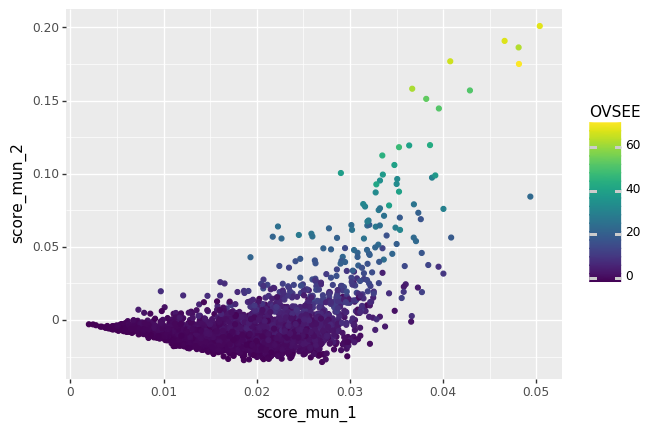

<ggplot: (8737109176310)>

In [34]:
(ggplot(marginacion, aes('score_mun_1', 'score_mun_2', color='OVSEE')) + geom_point())